In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from scipy.interpolate import RectBivariateSpline

In [ ]:
def getPoints(image):
    img1 = Image.open(image)
    plt.figure(1,figsize=(20,20))
    plt.imshow(img1)
    print("Please click")
    x = plt.ginput(8)
    return x


In [ ]:
pts_dst = getPoints(fileB)
pts_src = getPoints(fileA)

plt.close()


corrs = np.concatenate((pts_src, pts_dst), axis=1)
z = np.reshape(corrs, ((6, 4)))

aList = []
for corrr in z:
    p1 = np.matrix([corrr.item(0), corrr.item(1), 1])
    p2 = np.matrix([corrr.item(2), corrr.item(3), 1])

    a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
          p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
    a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
          p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
    aList.append(a1)
    aList.append(a2)

matrixA = np.matrix(aList)

# svd composition
u, s, v = np.linalg.svd(matrixA)

# reshape the min singular value into a 3 by 3 matrix
h3 = np.reshape(v[8], (3, 3))

# normalize and now we have h
h3 = (1 / h3.item(8)) * h3

print('shvdH', h3)

In [ ]:
h=[[ 1.11904971e+00 ,-4.82501219e-02 ,-4.98476818e+02],
 [ 6.77242250e-02 , 1.04963225e+00 ,-7.57993822e+01],
 [ 8.72387173e-05 , 1.66154504e-05 , 1.00000000e+00]]


h=np.array(h)
h.shape

(3, 3)

In [ ]:
def warp_image(image, H):

    """Warps an image using the homography matrix H.
    Args:
        image (numpy.ndarray): image to be warpped.
        H (numpy.ndarray) : Homography matrix used to warp the image.
    
    Returns:
        (tuple of numpy.ndarray, int, int):
            first element: the warpped images.
            second element: the minimum u corrdinate in corrdinate space not image space
                            this means this could be a negative number, in other words 
                            this is the amount of translation in the u diraction.
            third element: minimum v corrdcinate i.e. the translation in v direction.
    """

    H_inv = np.linalg.inv(H) 
    H_inv = H_inv / H_inv[2,2]
    # u == x
    # v == y
    

    orig_u_range = np.arange(image.shape[1])
    orig_v_range = np.arange(image.shape[0])

    _, transformed_image, = transform_grid(orig_u_range , orig_v_range, H)
    
    min_u=int(np.min(transformed_image[:,0]))
    max_u=int(np.max(transformed_image[:,0]))
    min_v=int(np.min(transformed_image[:,1]))
    max_v=int(np.max(transformed_image[:,1]))

    mapped_u_range = np.arange(min_u, max_u)
    mapped_v_range = np.arange(min_v, max_v)
    
    

    target_image = np.zeros((max_v-min_v, max_u-min_u,3))


    transformed_points, inv_transformed_image = transform_grid(mapped_u_range, mapped_v_range, H_inv)

    def fill_channel(target, channel, batch_size=64):
        I_cont = RectBivariateSpline(orig_v_range, orig_u_range, image[:,:,channel])

        n_iters =int( len(inv_transformed_image) / batch_size )
        
        for i in range(n_iters + 1):
            start = i * batch_size
            end = (i+1) * batch_size
            
            mapped_u_batch = inv_transformed_image[start:end, 0].ravel()
            mapped_v_batch = inv_transformed_image[start:end, 1].ravel()
            
            u_batch = transformed_points[start:end, 0].ravel()
            v_batch = transformed_points[start:end, 1].ravel()

            target[v_batch-min_v, u_batch-min_u, channel] = I_cont(mapped_v_batch, mapped_u_batch, grid=False)

    fill_channel(target_image, 0)
    fill_channel(target_image, 1)
    fill_channel(target_image, 2)
    #cv2_imshow(target_image)

    return target_image, min_u, min_v

In [ ]:
def transform_points(points, H):

    ones = np.ones((points.shape[0], 1))
    points = np.concatenate([points, ones], 1)

    mapped_points = np.dot(points, H.T)
    mapped_points[:,:-1] /= np.expand_dims(mapped_points[:,-1],1)
    mapped_points = mapped_points[:,:-1]

    return mapped_points

In [ ]:

def transform_grid(u_range, v_range, H):
   
    grid_u, grid_v = np.meshgrid( u_range, v_range )

    u_flat = np.expand_dims(np.ndarray.flatten(grid_u), 1)
    v_flat = np.expand_dims(np.ndarray.flatten(grid_v), 1)
    points = np.concatenate([u_flat, v_flat],1)
    
    return points, transform_points(points, H)

In [ ]:
def stitch(img2path,img1path,h):
    image=0
    image2 = cv2.imread(img2path)
    image1 = cv2.imread(img1path)
    
    warpped_image_1, min_u, min_v = warp_image(image2, np.array(h))

    res = np.zeros((warpped_image_1.shape[0] + image1.shape[0],
                    warpped_image_1.shape[1] + image1.shape[1], 3))

    shift_u_1 = min_u if min_u>0 else 0
    shift_v_1 = min_v if min_v>0 else 0



    shift_u_2 = -min_u if min_u<0 else 0
    shift_v_2 = -min_v if min_v<0 else 0
    res[shift_v_2:image1.shape[0] + shift_v_2      ,    shift_u_2:image1.shape[1] + shift_u_2, :] = image1


    res[shift_v_1:warpped_image_1.shape[0]+shift_v_1     , shift_u_1:warpped_image_1.shape[1]+shift_u_1-130 , :] = warpped_image_1[:,0:warpped_image_1.shape[1]-130,:]
 

    res = res[0:np.maximum(image2.shape[0], image1.shape[0]+500),
              0:np.maximum(image2.shape[1], image1.shape[1])+500]
  
    cv2.imwrite('final.png',res)
    #cv2_imshow(res)
    im = Image.open(r"final.png")
    im1 = im.crop((30, warpped_image_1.shape[1]-image1.shape[1], res.shape[1], res.shape[0]))
    im1.save('test.png')
    final=cv2.imread('test.png')
    final=cv2.medianBlur(final,5)
    cv2_imshow(final)
 

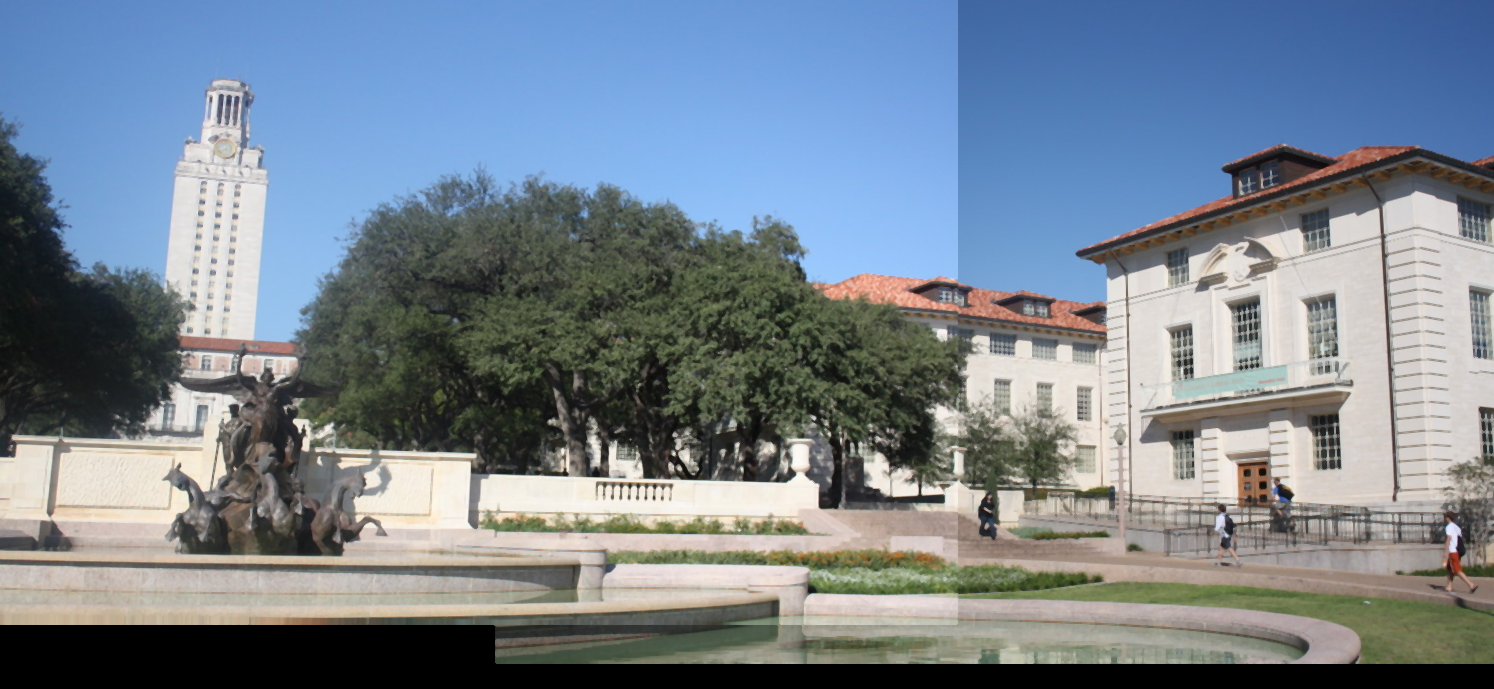

In [ ]:
stitch('image2.jpg','image1.jpg',h)

In [ ]:
h1=[[ 1.17618261e+00 , 5.52757682e-03 ,-4.07549121e+02],
 [ 9.01420140e-02,  1.19531489e+00 ,-8.80053104e+01],
 [ 1.17459491e-04 , 2.24448944e-04,  1.00000000e+00]]
#h1= [[ 1.05353772e+00 , 1.68250830e-03 ,-3.55965902e+02],
  # [ 7.04077860e-02 , 1.08615238e+00, -6.90106312e+01],
   #[ 2.68928702e-05 , 1.22701833e-04 , 1.00000000e+00]]
#h1= [[-9.85910097e-01, -1.82025310e+00 , 1.03247849e+03],
 #[-2.71043329e-01, -1.39233576e+00,  4.32352372e+02],
 #[-8.33095197e-04 ,-3.33920450e-03 , 1.00000000e+00]]
h1=np.array(h1)

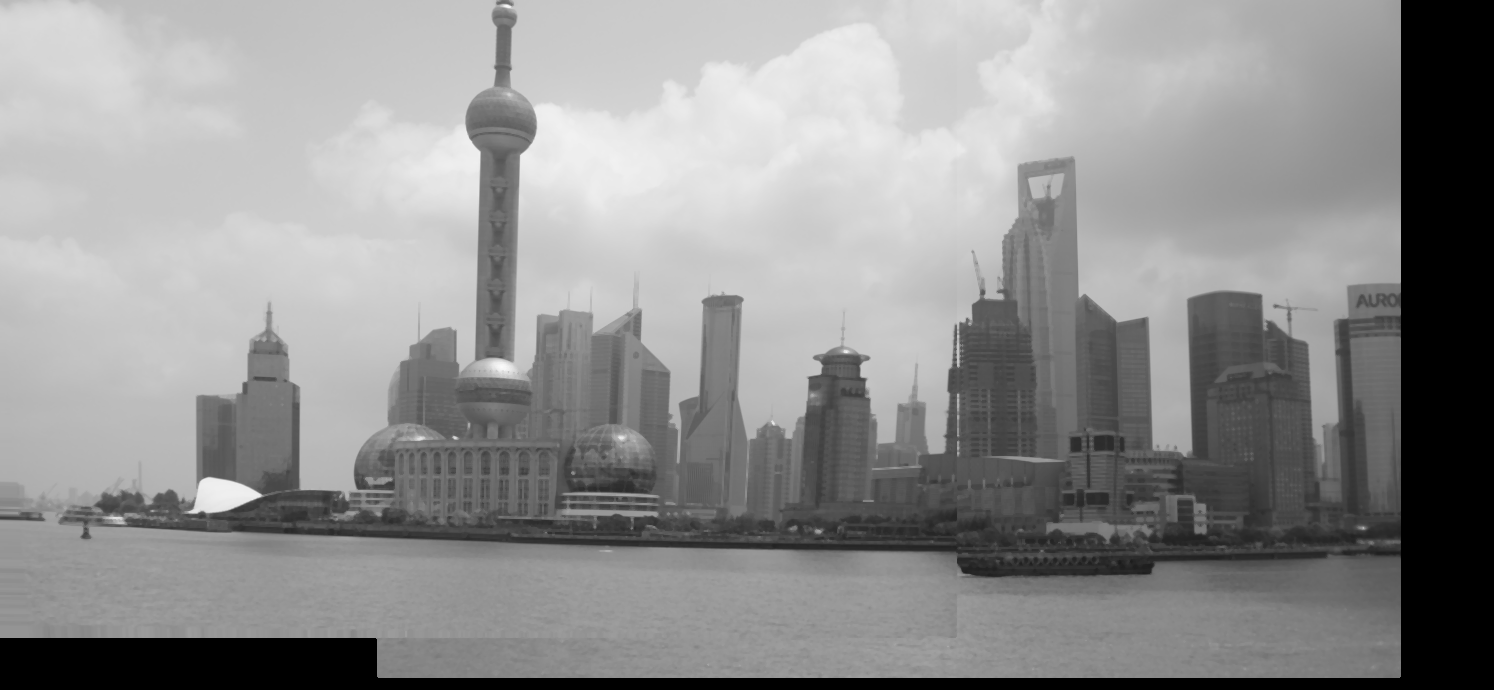

In [ ]:
stitch('shanghai-21.png','shanghai-23.png',h1)

In [ ]:
#h2=[[-3.66571010e-01, -3.16029990e-01 , 4.26969600e+02],
 #[-5.20919388e-01 , 5.24331570e-02 , 4.03434519e+02],
 #[-9.97858136e-04 ,-6.43154755e-04 , 1.00000000e+00]]
h2= [[ 8.32482628e-01 ,-3.07092707e-02 , 3.75225558e+01],
 [-1.23948843e-01,  8.72064371e-01,  2.80453901e+02],
 [-1.11003857e-04 ,-1.29439608e-04 , 1.00000000e+00]]
#h2= [[ 1.50492751e+00 , 7.48665766e-01 ,-2.62437738e+02],
 #[-6.63620502e-02 , 1.95244252e+00 , 2.16714013e+02],
 #[ 4.65933871e-05 , 1.44920869e-03,  1.00000000e+00]],

In [ ]:
h2= [[ 3.18707937e-01, -1.24102161e-01 , 2.13035608e+02],
 [-2.90967368e-01 , 5.50806553e-01 , 3.31987822e+02],
 [-4.70563890e-04 ,-3.11181461e-04 , 1.00000000e+00]]

In [ ]:
h2=[[ 1.77946843e+00 , 2.65714976e-01 ,-2.65647436e+02],
 [ 1.79679796e-01 , 1.59276226e+00 ,-4.72569204e+02],
 [ 4.42221639e-04 , 5.28861415e-04 , 1.00000000e+00]]

In [ ]:
h2=[[ 1.53376885e+00 , 2.29865665e-01 ,-1.92195000e+02],
 [ 1.15099891e-01 , 1.45161327e+00 ,-4.06300188e+02],
 [ 2.47429192e-04 , 4.62826076e-04  ,1.00000000e+00]]

In [ ]:
h2=[[ 1.02190191e+00, -6.97837232e-02 , 2.26177297e+01],
 [ 7.46094833e-02 , 9.99129834e-01 ,-2.68912748e+02],
 [ 6.24405538e-05 ,-1.00894012e-04 , 1.00000000e+00]]

In [ ]:
h2=[[ 1.29379731e+00,  1.50465802e-01 ,-1.09477517e+02],
 [ 9.09287721e-02  ,1.29825400e+00 ,-3.59534402e+02],
 [ 1.02024644e-04  ,3.14148191e-04 , 1.00000000e+00]]

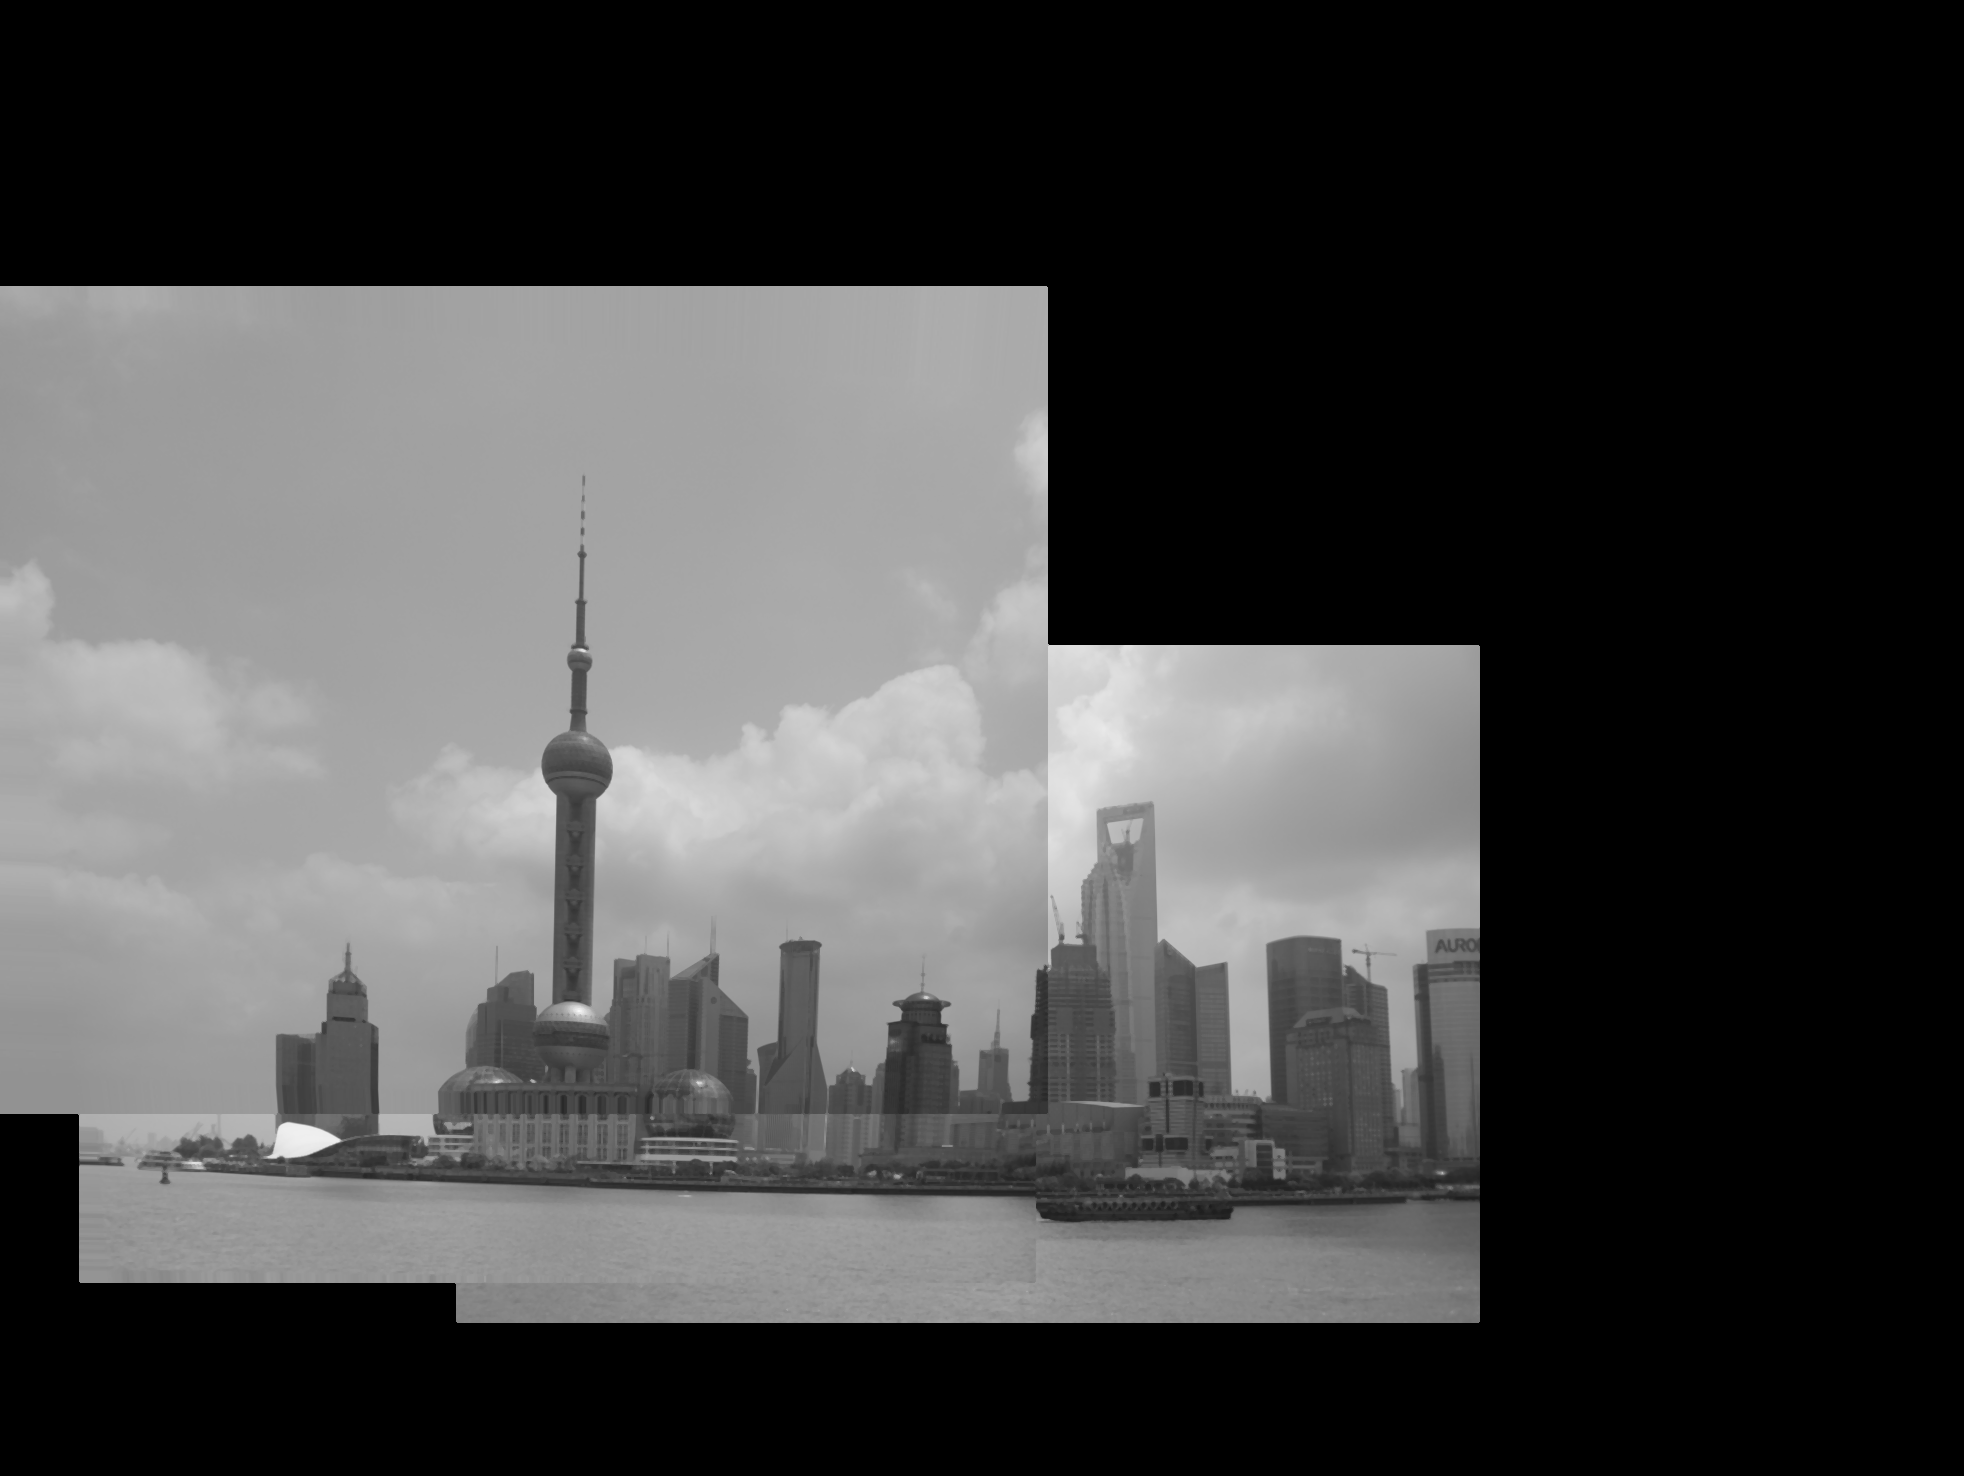

In [ ]:
stitch('shanghai-22.png','2images.png',h2)